In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load #from this package, we obtain some useful datasets for our analysis.
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info

In [2]:
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Import personalized functions (Pandas API)

In [4]:
%run pandas-missing-extension.ipynb

### Setting up general project plot overview.

In [5]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8,6)
    }
)
sns.set_style("whitegrid")
sns.set_style("whitegrid")

## Issues at time of working with missing values.

In [6]:
air_quality = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type="snake" #column names are transformed into snake_case type names.
    )
    .add_column("year", 1973)
    .assign(
        date=lambda df:pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by="date")
    .set_index("date")
)

air_quality

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [7]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=air_quality
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 14 Feb 2024",Prob (F-statistic):,2.93e-18
Time:,21:49:34,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [8]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=air_quality
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 14 Feb 2024",Prob (F-statistic):,1.47e-16
Time:,21:49:34,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


There are less observations in our linear regressions in contrast to complete `air_quality` dataset, this contains missing values.

### Challenge: Survival data

In [9]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data.clean_names(case_type="snake").rename(columns={"lambda":"lambda_var"})
survival_df.head()

,age,sex,sample_yr,kappa,lambda_var,flc_grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory


In [10]:
survival_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,7874,0.000000
1,sex,0,7874,0.000000
2,sample_yr,0,7874,0.000000
3,kappa,0,7874,0.000000
4,lambda_var,0,7874,0.000000
5,flc_grp,0,7874,0.000000
6,creatinine,1350,7874,17.145034
7,mgus,0,7874,0.000000
8,futime,0,7874,0.000000
9,death,0,7874,0.000000


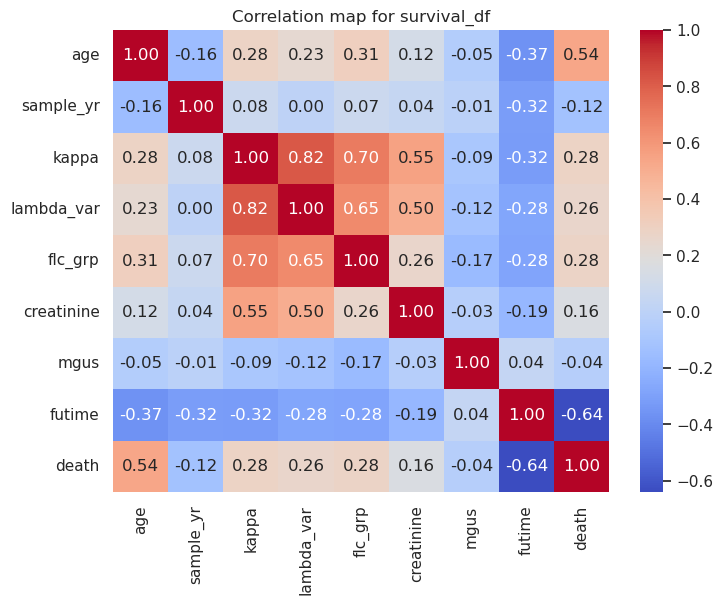

In [11]:
correlation_matrix = survival_df.corr(numeric_only=True)
plt.title("Correlation map for survival_df")
sns.heatmap(
    data=correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.show()

In [12]:
(
    smf.ols(
        formula="death ~ age+kappa+flc_grp+lambda_var",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,death,R-squared:,0.309
Model:,OLS,Adj. R-squared:,0.308
Method:,Least Squares,F-statistic:,878.6
Date:,"Wed, 14 Feb 2024",Prob (F-statistic):,0.00
Time:,21:49:35,Log-Likelihood:,-3374.5
No. Observations:,7874,AIC:,6759.
Df Residuals:,7869,BIC:,6794.
Df Model:,4,,
Covariance Type:,nonrobust,,


In [13]:
(
    smf.ols(
        formula="death ~ creatinine",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,death,R-squared:,0.025
Model:,OLS,Adj. R-squared:,0.025
Method:,Least Squares,F-statistic:,165.0
Date:,"Wed, 14 Feb 2024",Prob (F-statistic):,2.59e-37
Time:,21:49:35,Log-Likelihood:,-4089.4
No. Observations:,6524,AIC:,8183.
Df Residuals:,6522,BIC:,8196.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [14]:
# (
#     smf.logit(
#         formula="death ~ C(chapter)",
#         data=survival_df
#     )
#     .fit()
#     .summary()
#     .tables[0]
# )
#it is probably that missing values affect this perfect separation.

### Loading NHANES data

In [15]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018") #column names are written in PascalCase
    .clean_names(case_type="snake")
)
nhanes_raw_df.shape

(8366, 197)

### Process NHANES data

In [16]:
nhanes_raw_df.head()

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
nhanes_raw = (
    nhanes_raw_df
    .select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns(
        {
            "age_in_years_at_screening": "age",
            "current_selfreported_height_inches" : "height",
            "current_selfreported_weight_pounds" : "weight",
            "doctor_told_you_have_diabetes" : "diabetes",
            "60_sec_pulse30_sec_pulse2" : "pulse",
            "total_cholesterol_mgdl" : "total_cholesterol"
        }
    )
)

In [18]:
nhanes_raw.describe()

,age,height,weight,pulse,total_cholesterol
count,8366.000000,5776.000000,5828.000000,6742.000000,6738.000000
mean,35.830026,272.224030,350.995710,73.749926,179.894627
std,24.905061,1414.518896,1280.908078,12.380546,40.602248
min,1.000000,49.000000,72.000000,34.000000,76.000000
25%,12.000000,63.000000,145.000000,66.000000,151.000000
50%,33.000000,66.000000,171.500000,72.000000,176.000000
75%,59.000000,70.000000,208.000000,82.000000,204.000000
max,80.000000,9999.000000,9999.000000,136.000000,446.000000


In [19]:
nhanes_raw.head(10)

,general_health_condition,age,gender,height,weight,diabetes,pulse,total_cholesterol
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
93708.0,Good,66.0,Female,60.0,118.0,Borderline,68.0,209.0
93709.0,NaN,75.0,Female,62.0,200.0,0,74.0,176.0
93711.0,Very good,56.0,Male,69.0,142.0,0,62.0,238.0
93712.0,Good,18.0,Male,68.0,135.0,0,68.0,182.0


As we can appreciate in the above table, both `weight` and `height` columns have extreme values as 9999.00 in inches and pounds, respectively. Those could be probably missing values in an implicit manner.

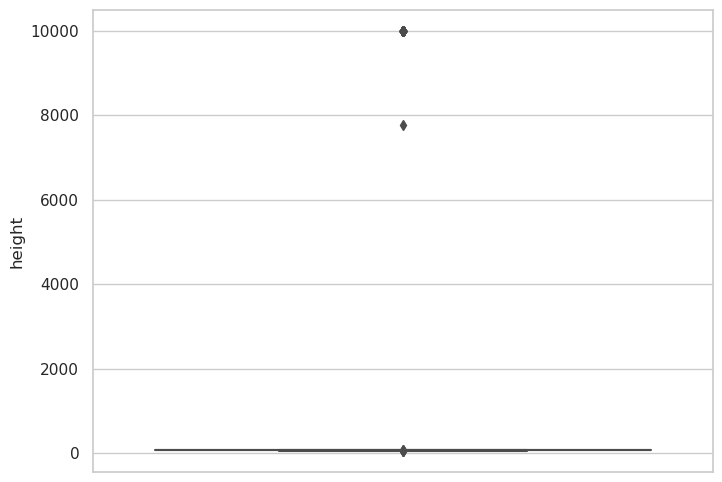

In [20]:
(
    nhanes_raw
    .pipe(
        lambda df: ( #try to use matplotlib subplots to craft a double view with showfliers: True, False
            sns.boxplot(
                data=df,
                y="height",
                showfliers=True
            )
        )
    )
)
plt.show()

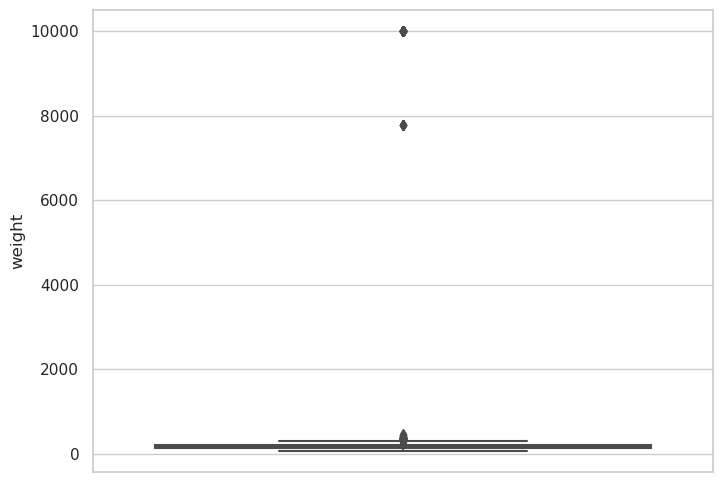

In [21]:
(
    nhanes_raw
    .pipe(
        lambda df: ( #try to use matplotlib subplots to craft a double view with showfliers: True, False
            sns.boxplot(
                data=df,
                y="weight",
                showfliers=True
            )
        )
    )
)
plt.show()

In [22]:
nhanes_df = (
    nhanes_raw
    .replace(
        {
            "height" : {
                9999 : np.nan,
                7777 : np.nan, #it is also included (please check it up)
            },
            
            "weight" : {
                9999 : np.nan,
                7777 : np.nan, #it is also included (please check it up)
            },
            "diabetes" : {
                "Borderline" : np.nan #this string within our column may hinder our following .transform_column() method 
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how="any"
    )
    .transform_column( #comes from pyjanitor
        column_name="diabetes",
        function=lambda s:s.astype(int),
        elementwise=False
    )
)

nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


### Visualizing missing values of `nhanes_df`

<AxesSubplot:>

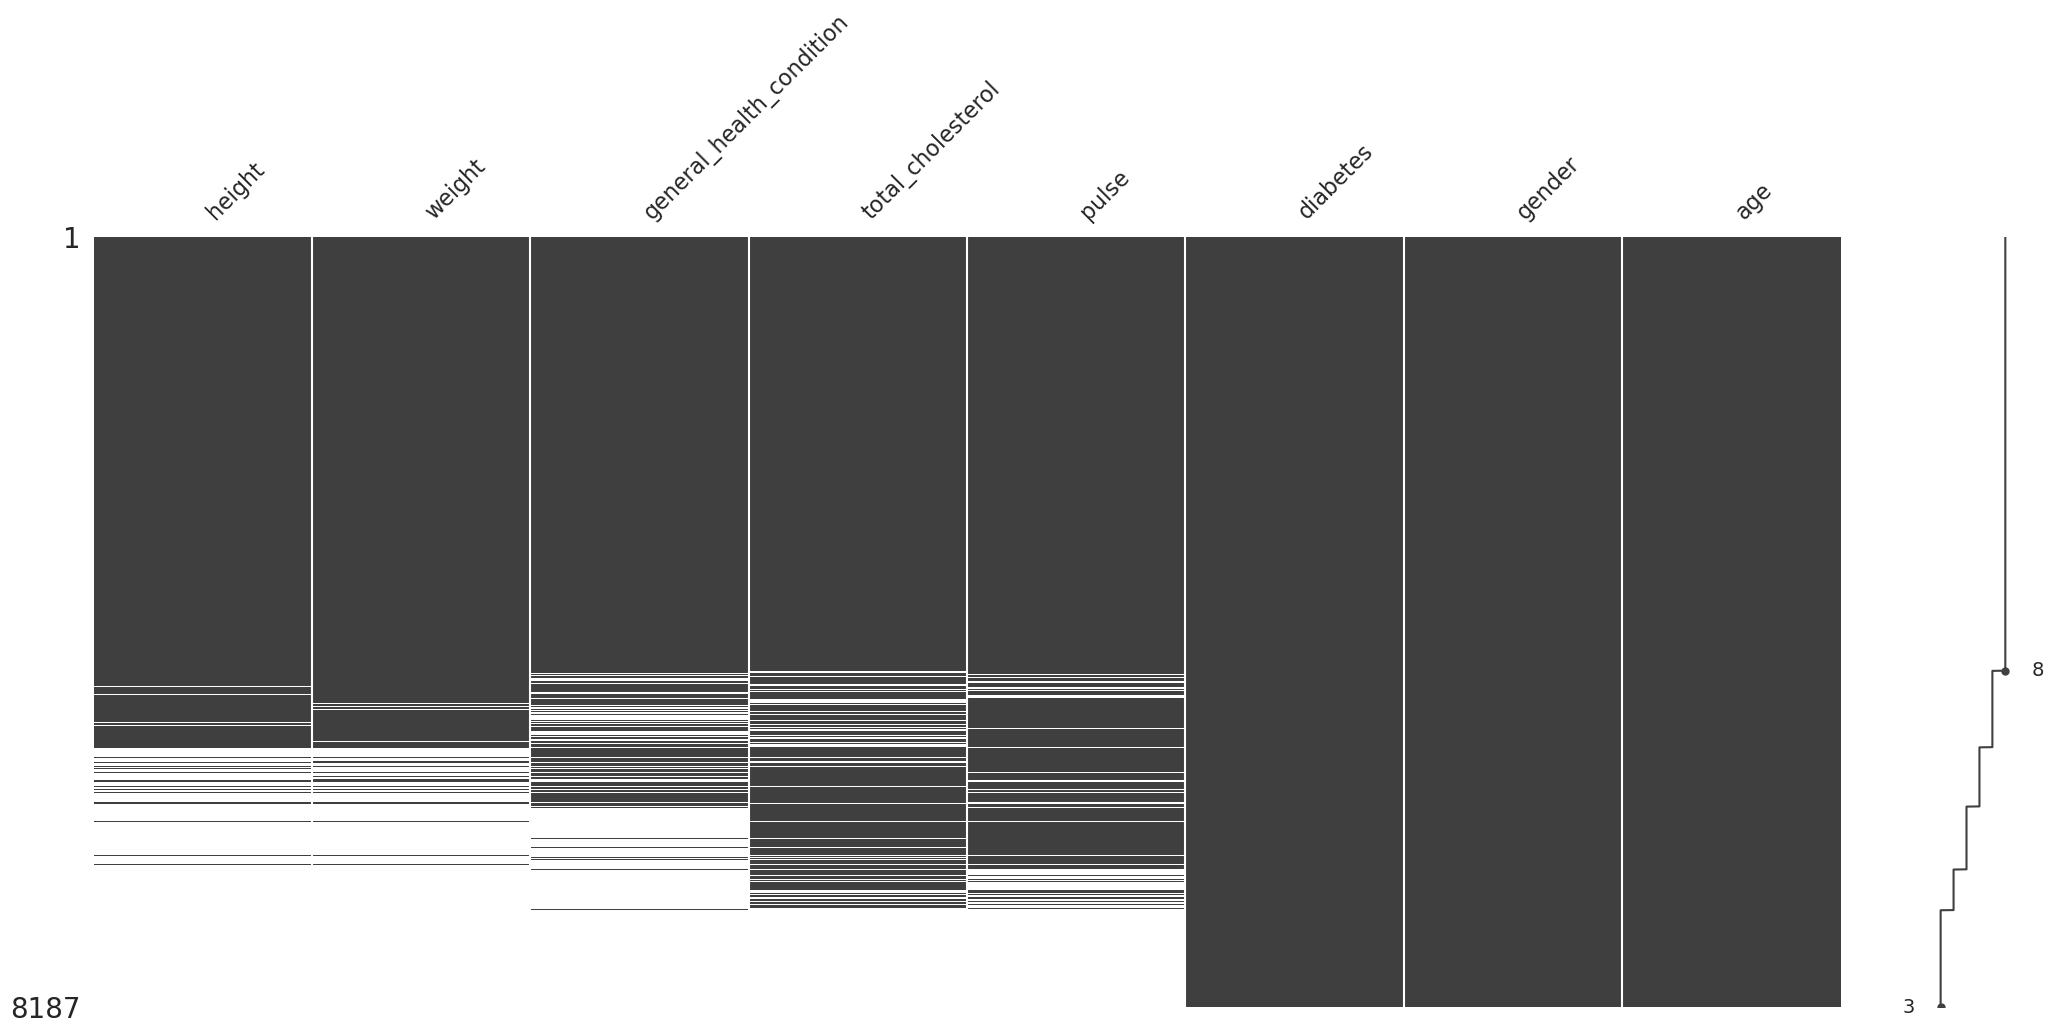

In [23]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort="descending") # sort plots in a descending manner (missingness).
)

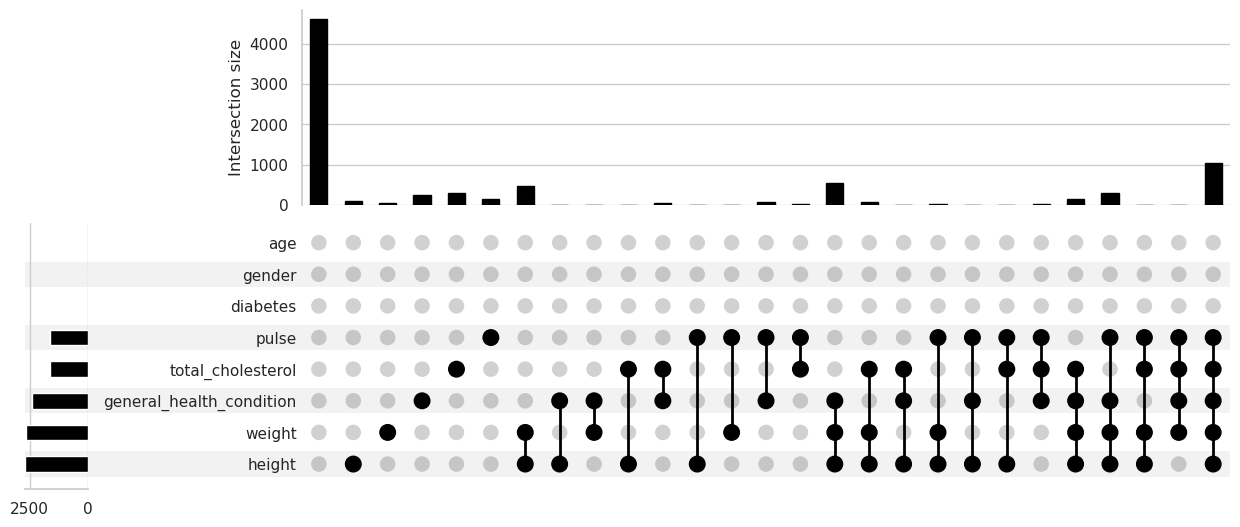

In [24]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)
plt.show()

### Deleting missing values

In [25]:
nhanes_df = (
    nhanes_df
    .dropna(
        subset=["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how="all"
    )
    .missing.sort_variables_by_missingness()
)

print(f"The original shape of our nhanes dataset was {nhanes_raw_df.shape[0]}, and our current is {nhanes_df.shape[0]}")

The original shape of our nhanes dataset was 8366, and our current is 7157


We can modularize this input analysis via import an external notebook as `data-and-load-it.ipynb`, with the goal of reducing some content in the main notebook. In this from `Loading NHANES data` until `Deleting missing values`

### Assessment of several types of missing values.

In [26]:
#Assessed by t-test
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise=False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)


In [27]:
scipy.stats.ttest_ind(
    a=female_weight,
    b=male_weight,
    alternative="two-sided"
)

TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

### Broadening toolkit for exploring missing values

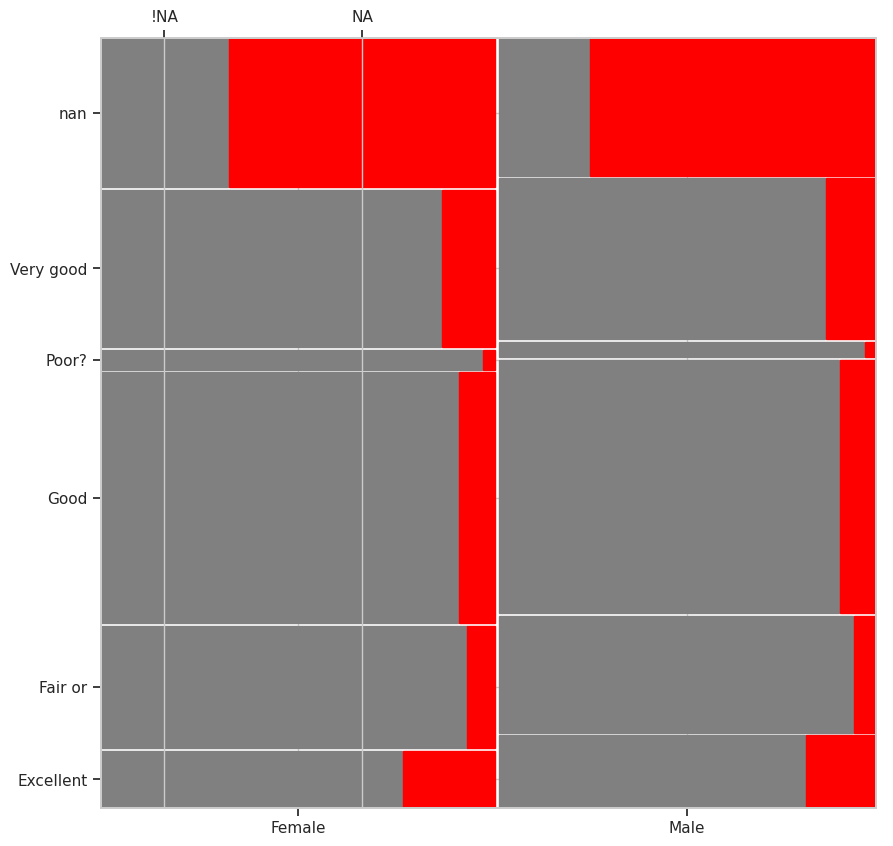

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns("general_health_condition", "weight", "gender")
    .assign(
        weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]) # Replacing weight missing values in weight column.
    )
    .groupby(
        ["gender","general_health_condition","weight"],
        dropna=False,
        as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color":"red" if "NA" in key else "gray"},
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
            ax=ax
        )
    )
);

In [29]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [30]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [31]:
encoder.fit_transform(X), encoder.categories_

(array([[1.],
        [0.],
        [0.]]),
 [array(['Female', 'Male'], dtype=object)])

In [32]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

##### Applying ordinal coding to categorical variables

In [33]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [34]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [35]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(), # remained_ and ordinalencoder_ is added to our original columns name.
        index=nhanes_df.index
    )
    .rename_columns(
        function=lambda x:x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function=lambda x:x.removeprefix("remainder__")
    )
)

#### One-hot encoding

In [36]:
nhanes_transformed_df_2 = nhanes_df.copy(deep=True)

`pandas.get_dummies()`

In [37]:
(
    nhanes_transformed_df_2
    .select_columns("general_health_condition")
    # .head(10) # in this case, our current table just have some few categorical values: [Very good, good, Fair]
    .pipe(
        pd.get_dummies
    )
    .rename_columns(
        function=lambda x:x.removeprefix("general_health_condition_")
    )
    .rename(
        columns={'Poor?':'Poor'}
    )
)

,Excellent,Fair or,Good,Poor,Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


`sklearn.preprocessing.OneHotEncoder()`

In [38]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [39]:
nhanes_transformed_df_2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(), # remained_ and ordinalencoder_ is added to our original columns name.
        index=nhanes_df.index
    )
    .rename_columns(
        function=lambda x:x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function=lambda x:x.removeprefix("remainder__")
    )
    .rename_columns(
        function=lambda x:x.removeprefix("onehotencoder__general_health_condition_")
    )
)

nhanes_transformed_df_2

,gender,Excellent,Fair or,Good,Poor?,Very good,nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [40]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [41]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,0,1,0,0,0], [0,1,0,0,0,0]]
    )
)

array([['Good'],
       ['Fair or']], dtype=object)

### Types of imputing methods
#### Single value imputing (mean, median, mode)

In [42]:
(
    nhanes_df
    .height
    .mean()
)

66.25655976676384

In [43]:
(
    nhanes_df
    #janitor
    .transform_column(
        "height",
        lambda x:x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

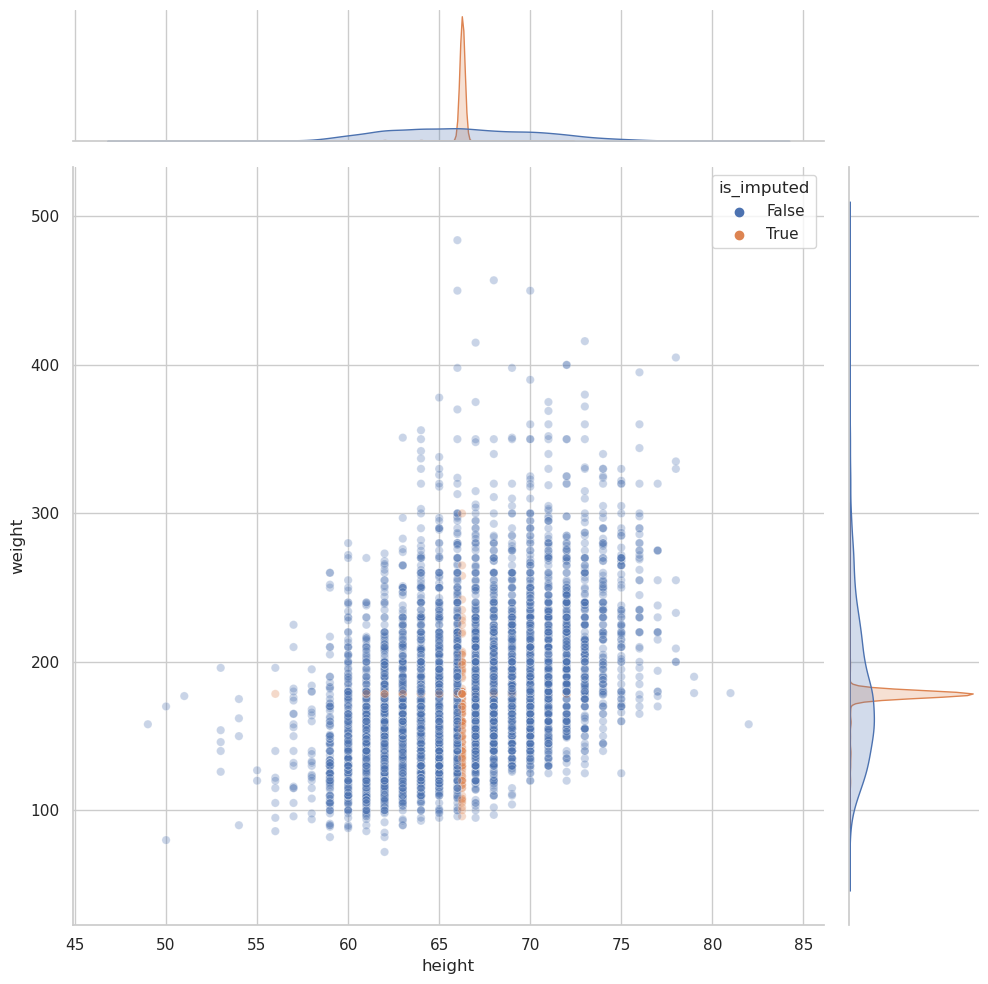

In [44]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(
        true_string=True, 
        false_string=False,
        suffix="_imp"
        )
    .assign(
        height=lambda df:df.height.fillna(value=df.height.mean()),
        weight=lambda df:df.weight.fillna(value=df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10,
        alpha=0.3
    )
)
plt.show()

As we can observe in our plot above, distribution of imputed values are not a problem for statistic biasing with `fillna(mean())` in the case of our `nhanes_df` for `weight` and `height`.

### Hot-deck and Cold-deck imputation
##### `fillna()` vs `ffill()` or `bfill()`

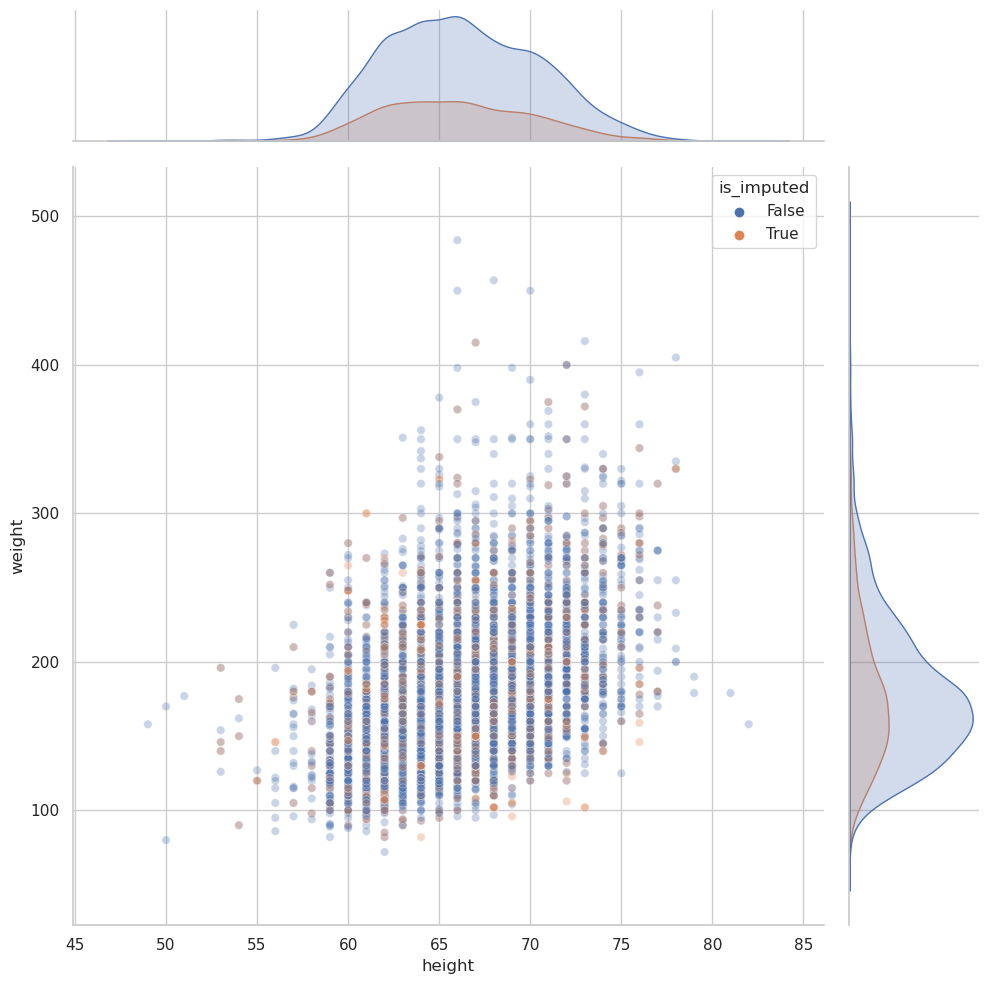

In [45]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(
        true_string=True, 
        false_string=False,
        suffix="_imp"
        )
    .assign(
        height=lambda df:df.height.fillna(method="ffill"),
        weight=lambda df:df.weight.fillna(method="ffill")
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10,
        alpha=0.3
    )
)
plt.show()


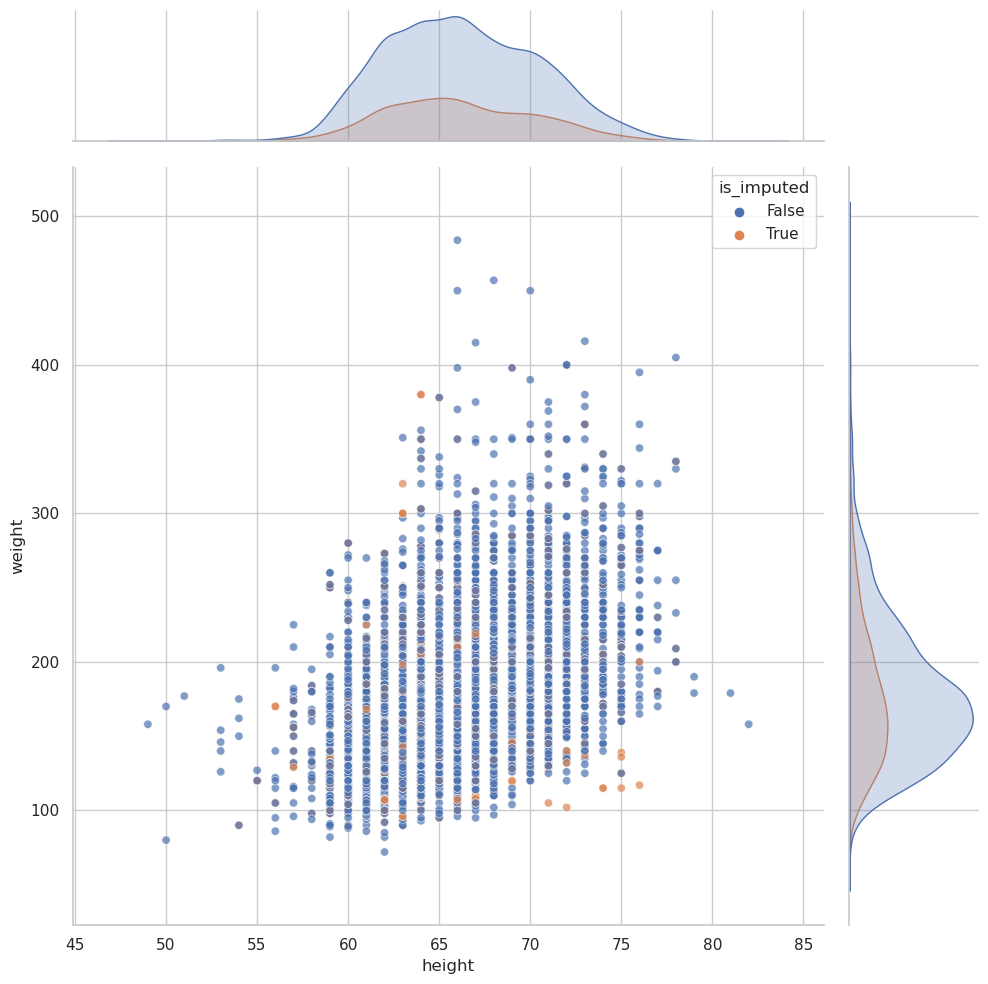

In [46]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(
        true_string=True, 
        false_string=False,
        suffix="_imp"
        )
    .assign(
        height=lambda df:df.height.fillna(method="bfill"),
        weight=lambda df:df.weight.fillna(method="bfill")
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10,
        alpha=0.7
    )
)
plt.show()

##### **Tips at moment of using `ffill()` or `bfill()`**
Imputation within domains and imputation through correlated variables

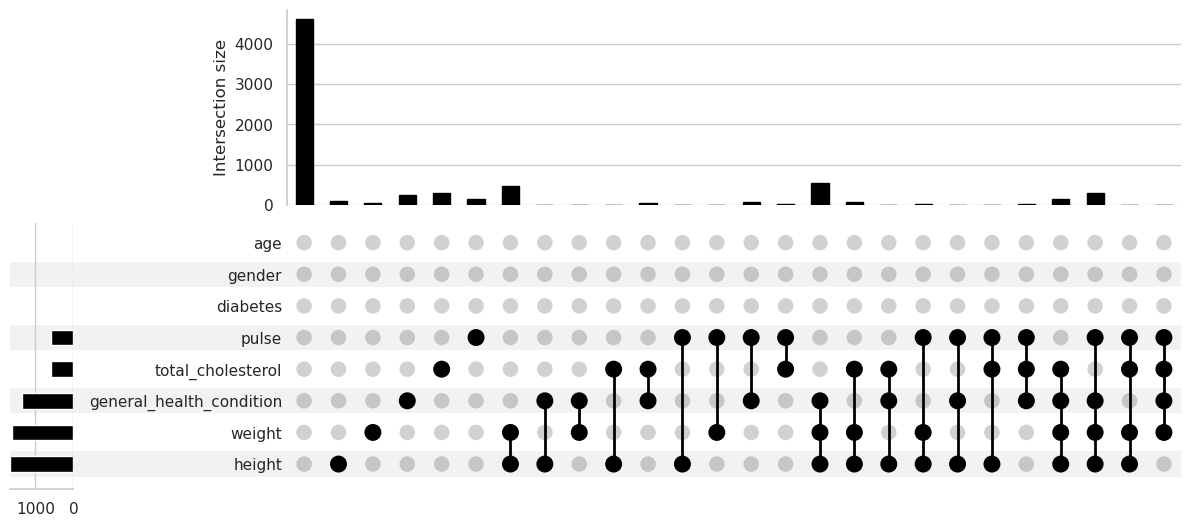

In [47]:
(
    nhanes_df
    .missing.missing_upsetplot()
)
plt.show()

In [48]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=["gender", "diabetes", "general_health_condition", "weight"],
        ascending=True
    )
    .transform_column(
        column_name="weight",
        function=lambda x: x.ffill(),
        elementwise=False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,NaN,298.0,Male,1,NaN


Imputation using groupby (Task https://medium.com/@yoavyeledteva/-167759acb579#:~:text=Domain%2Dspecific%20imputation%3A%20This%20involves,can%20guide%20the%20imputation%20process.)

### Imputation by interpolation

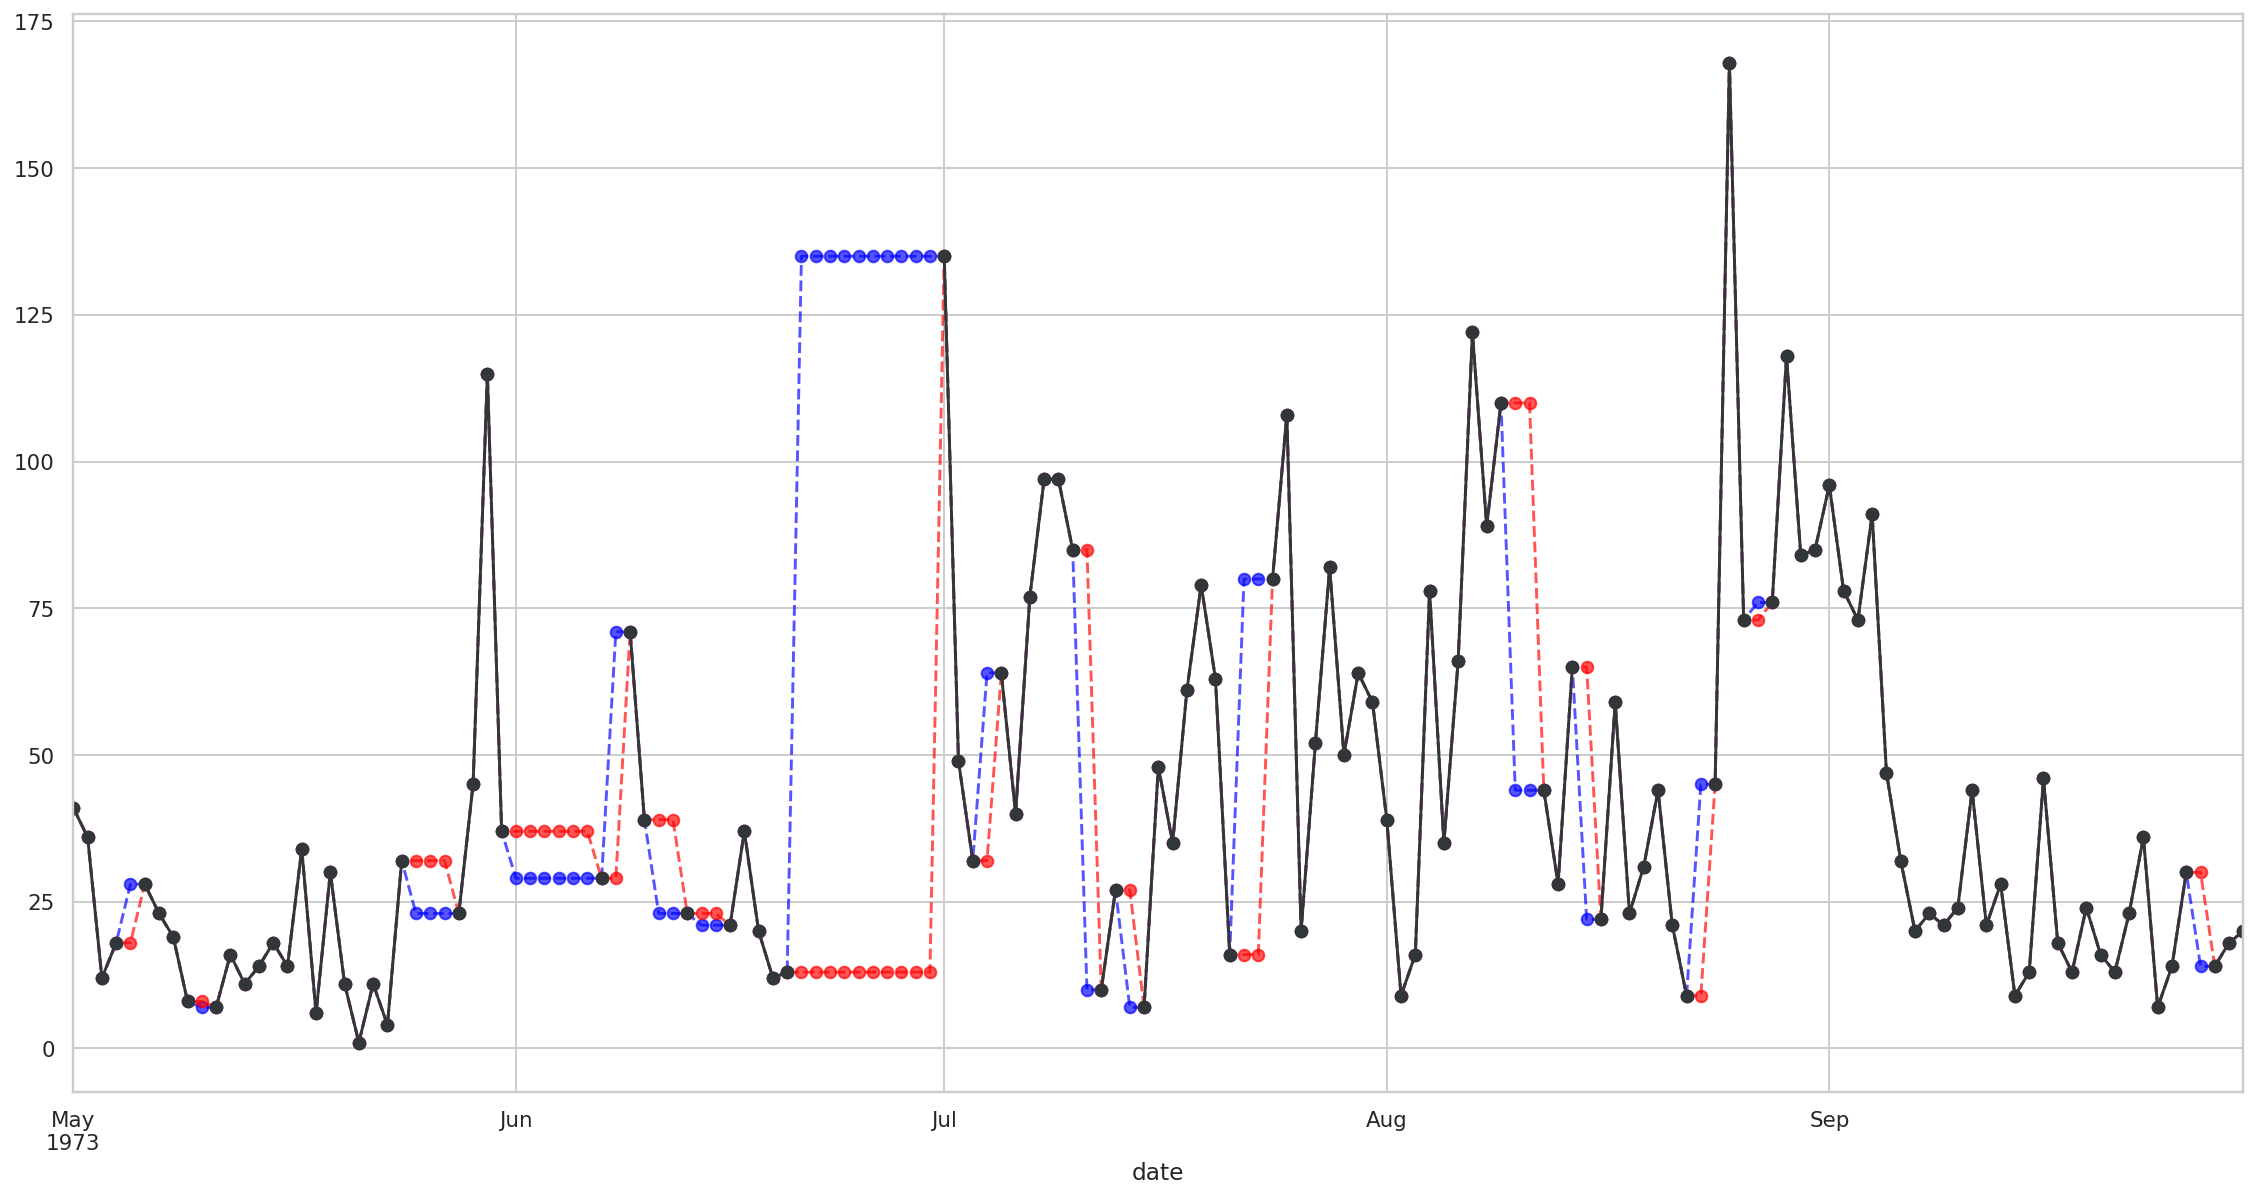

In [49]:
plt.figure(figsize=(20,10), dpi=140)
(
    air_quality
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color="blue", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.ffill().plot(color="red", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color="#313638", marker="o")
        )
    )
);

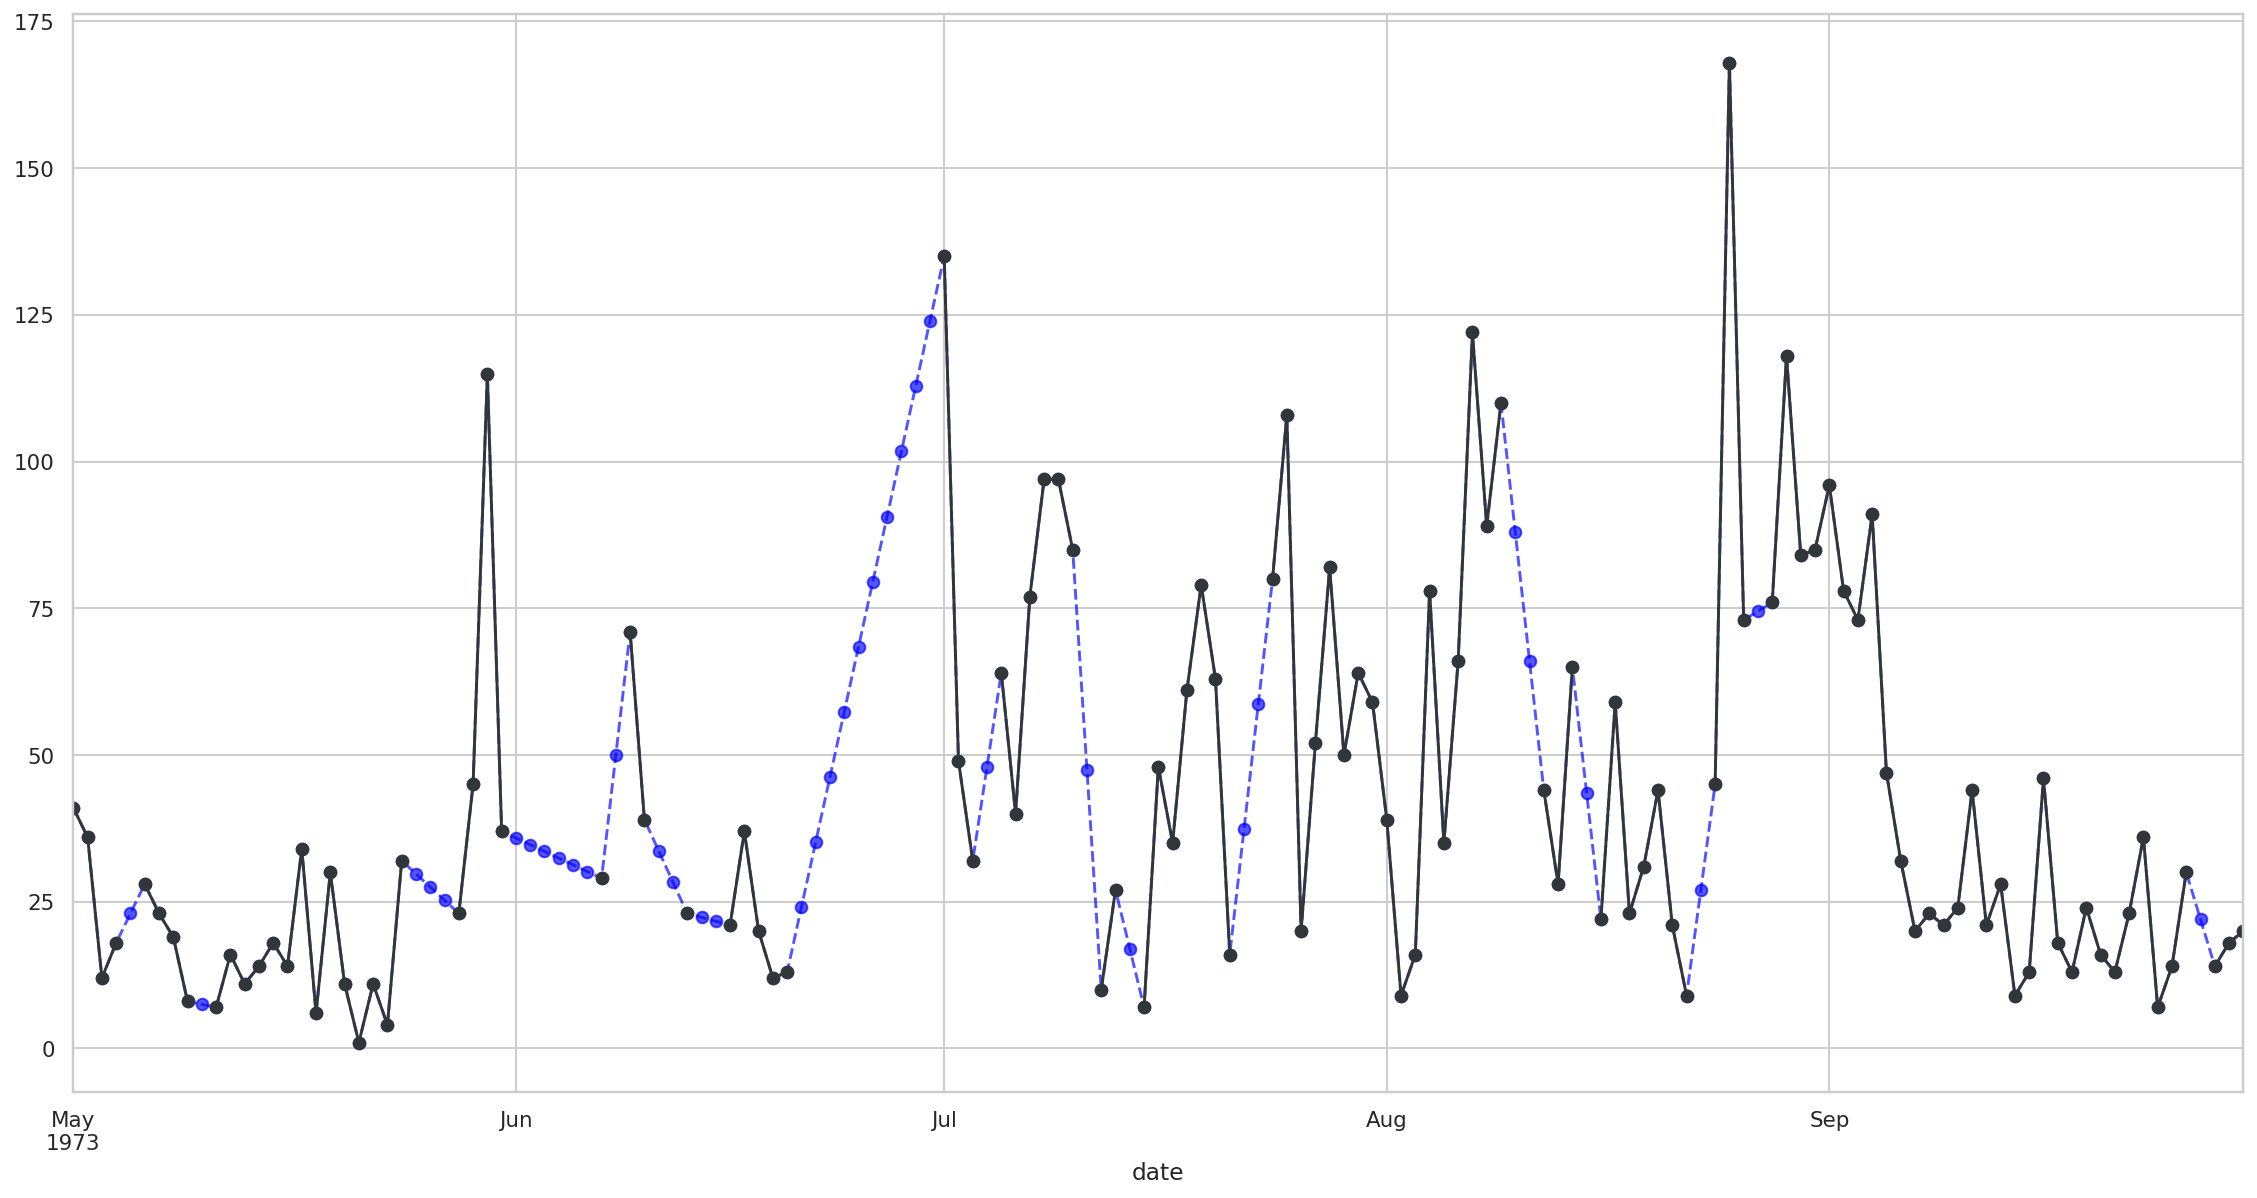

In [50]:
plt.figure(figsize=(20,10), dpi=140)
(
    air_quality
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method="linear").plot(color="blue", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color="#313638", marker="o")
        )
    )
);

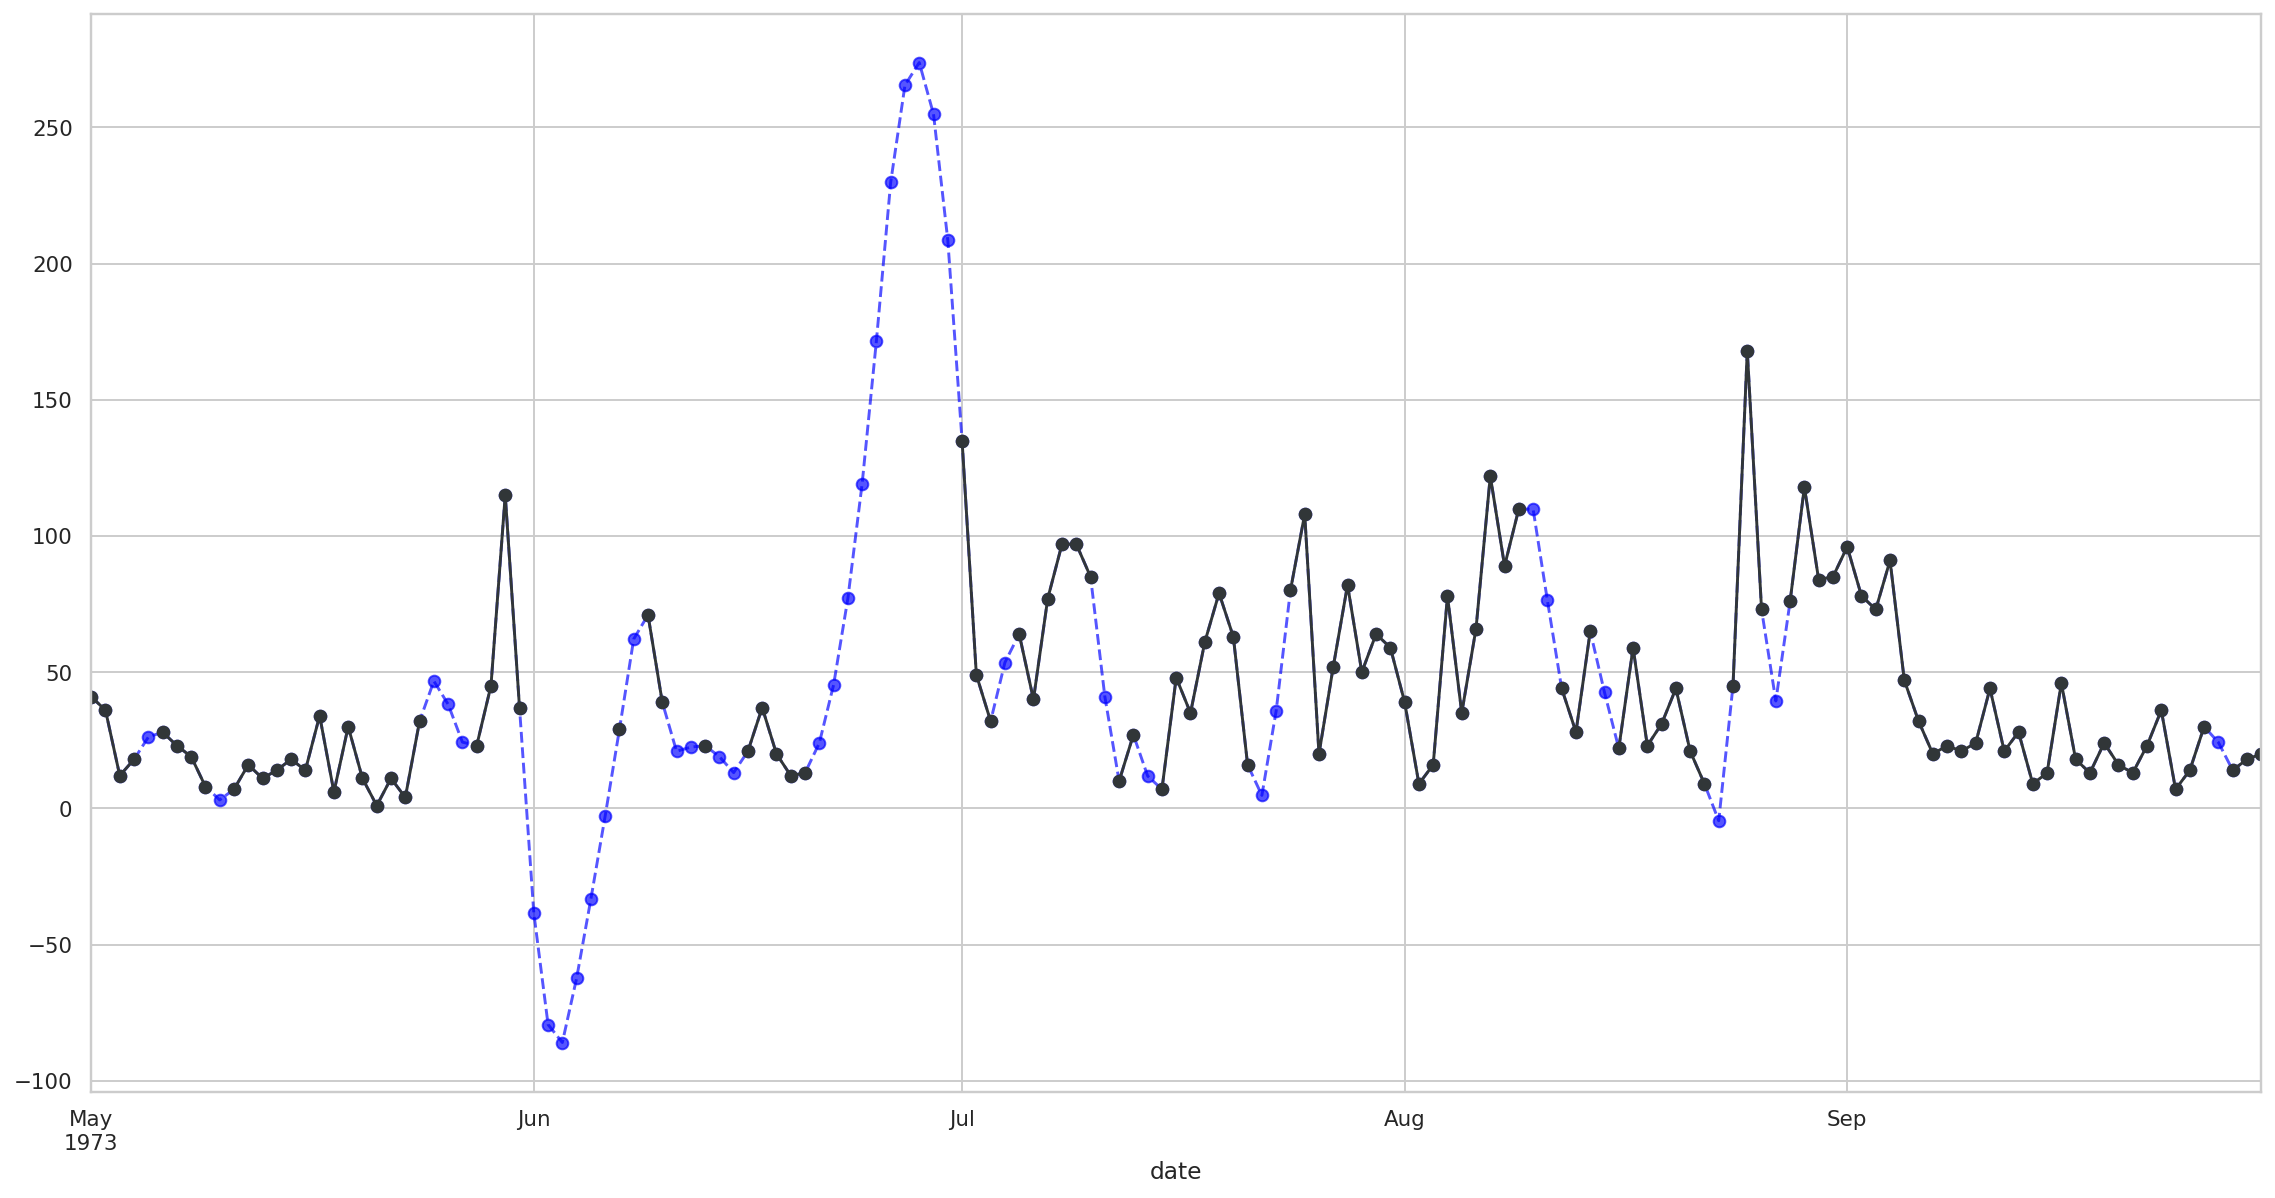

In [51]:
plt.figure(figsize=(20,10), dpi=140)
(
    air_quality
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method="quadratic").plot(color="blue", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color="#313638", marker="o")
        )
    )
);

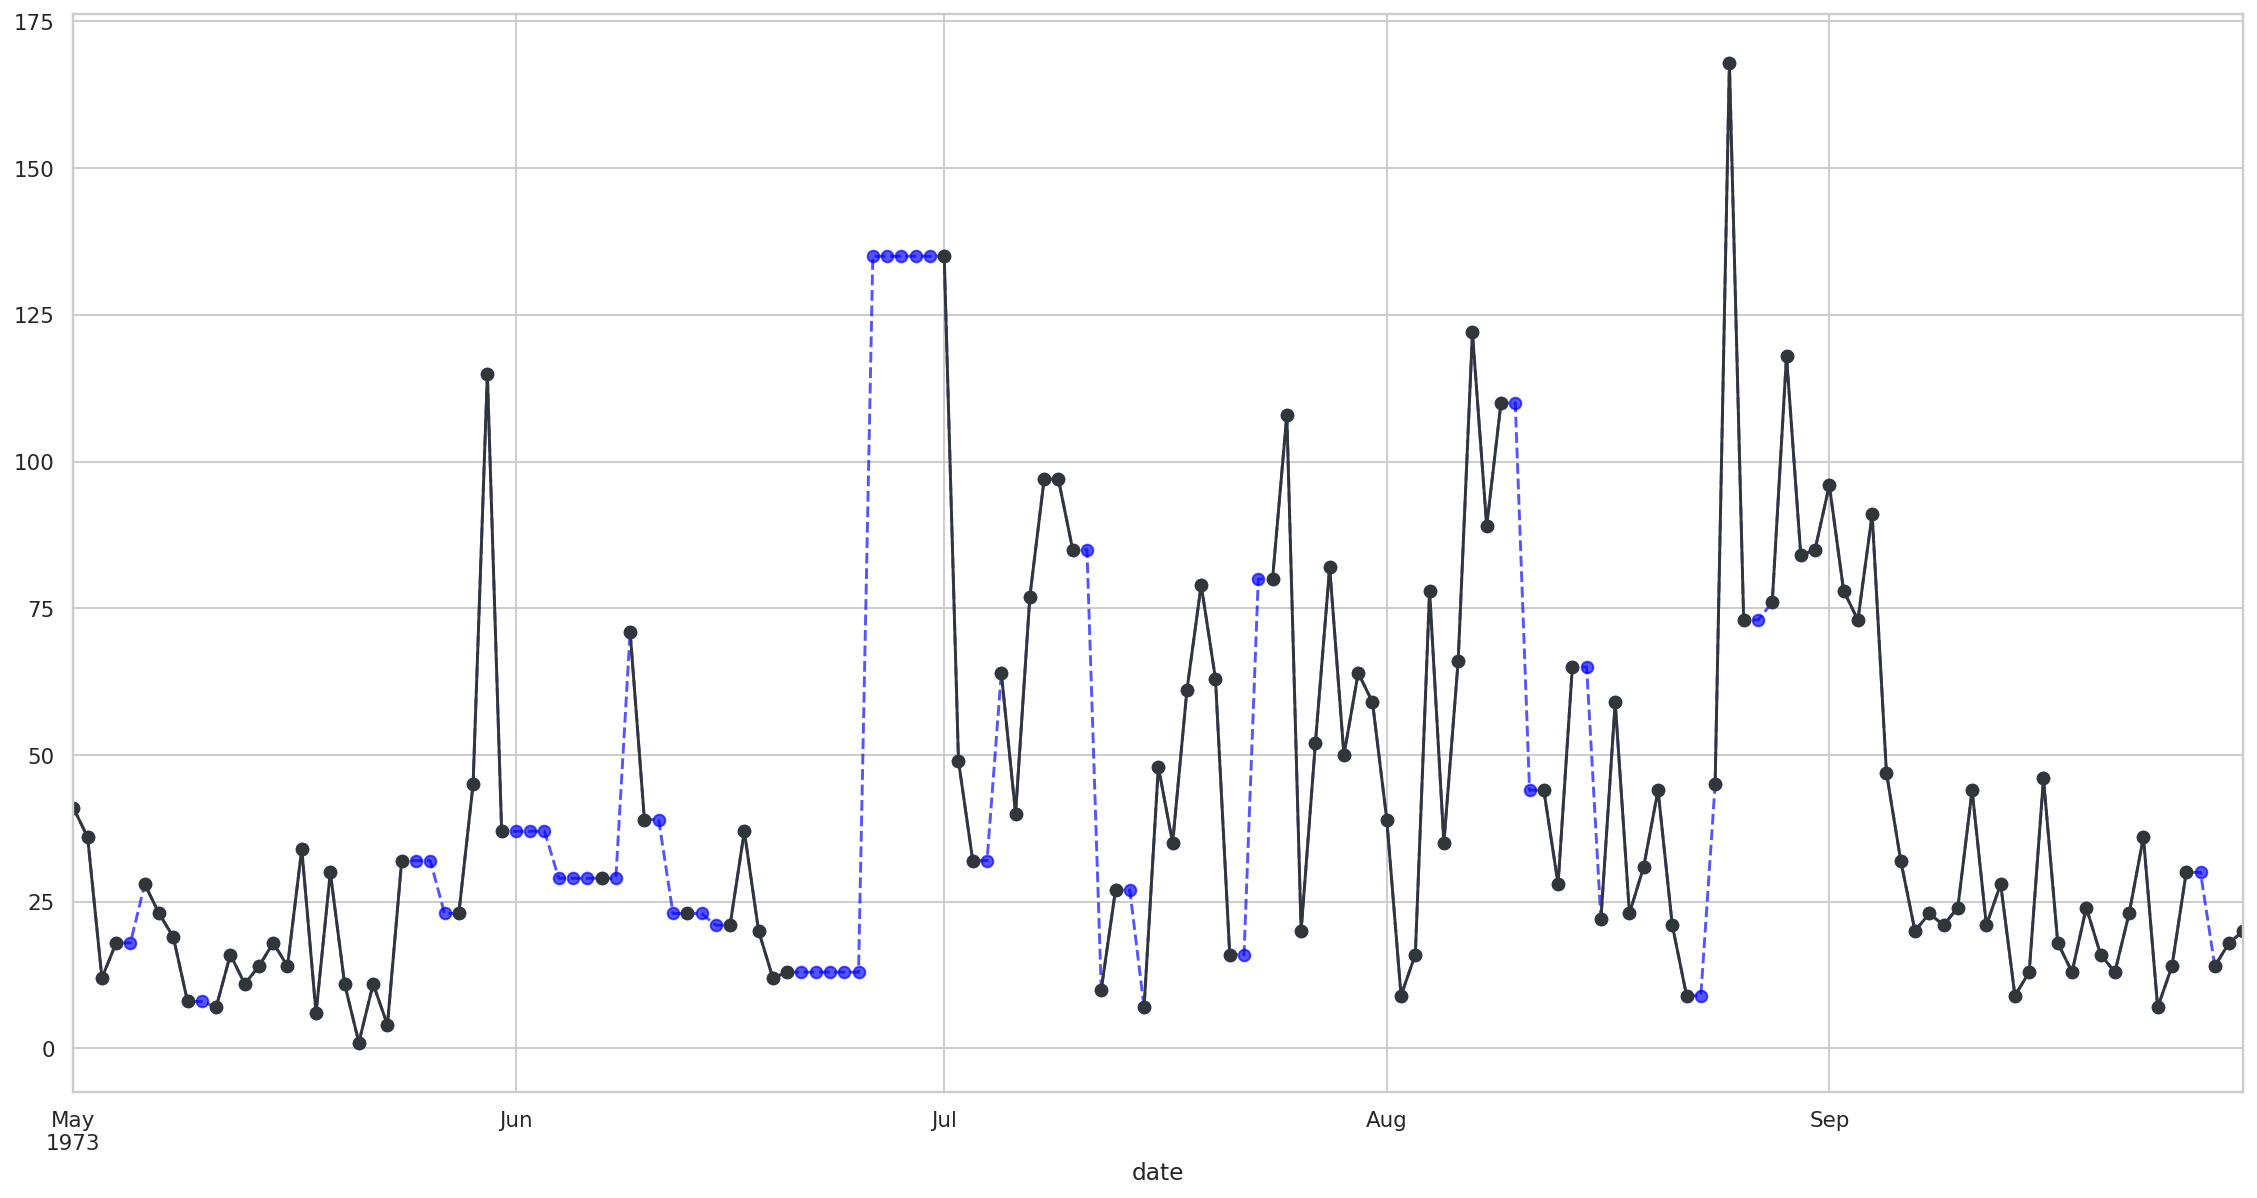

In [52]:
plt.figure(figsize=(20,10), dpi=140)
(
    air_quality
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method="nearest").plot(color="blue", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color="#313638", marker="o")
        )
    )
);

#### `Imputation by KNN`

In [53]:
nhanes_df.select_dtypes(object, "category")

,general_health_condition,gender
SEQN,,
93705.0,Good,Female
93706.0,Very good,Male
93707.0,Good,Male
93709.0,NaN,Female
93711.0,Very good,Male
...,...,...
102949.0,Excellent,Male
102953.0,Fair or,Male
102954.0,Good,Female


In [54]:
nhanes_transformed_df # ordinal encoding.

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [55]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)
nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transformed_df).round() # imputed missing vals for every column.
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


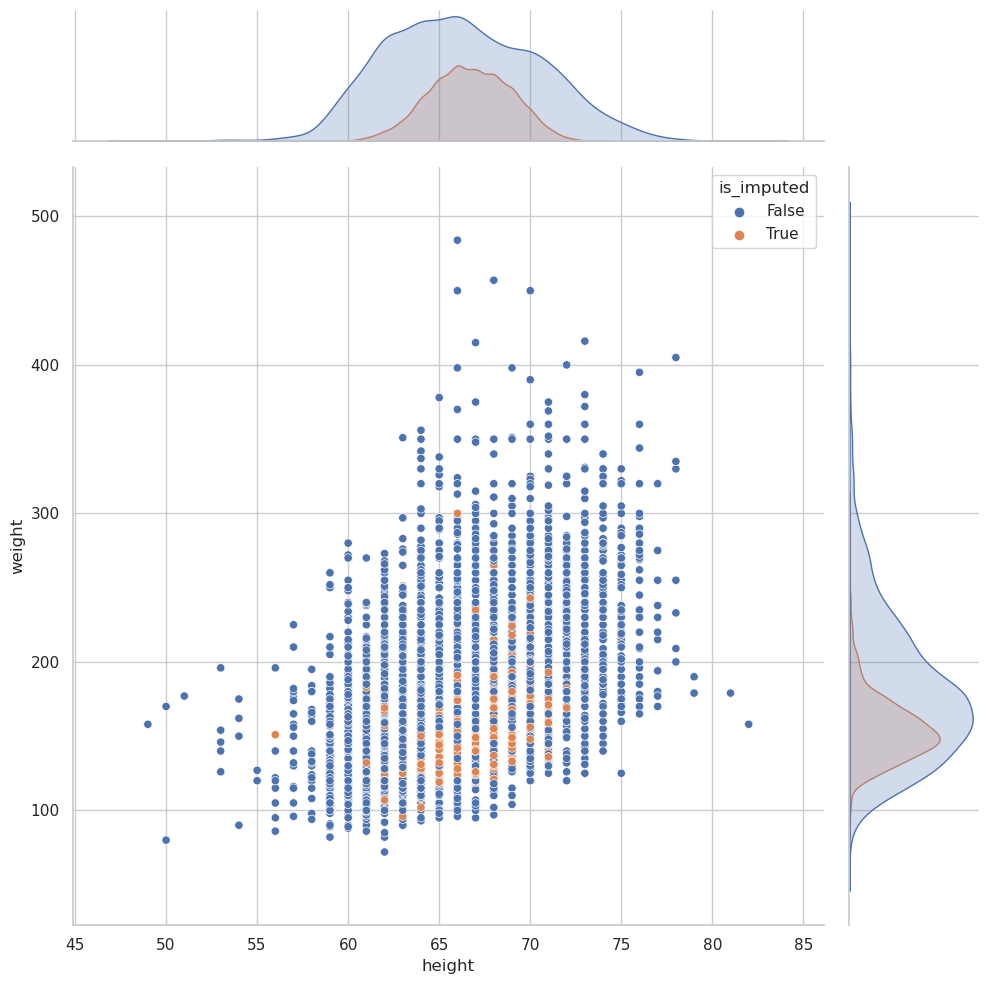

In [56]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        height=10,
        show_marginal=True
    )
);

#### Arranging by amount of missing variables.

In [57]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)
nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round() # imputed missing vals for every column.
nhanes_df_knn

,gender,age,diabetes,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,66.0,0.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,18.0,0.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,13.0,0.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,75.0,0.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,56.0,0.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,33.0,0.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,42.0,0.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,41.0,0.0,78.0,172.0,2.0,150.0,66.0


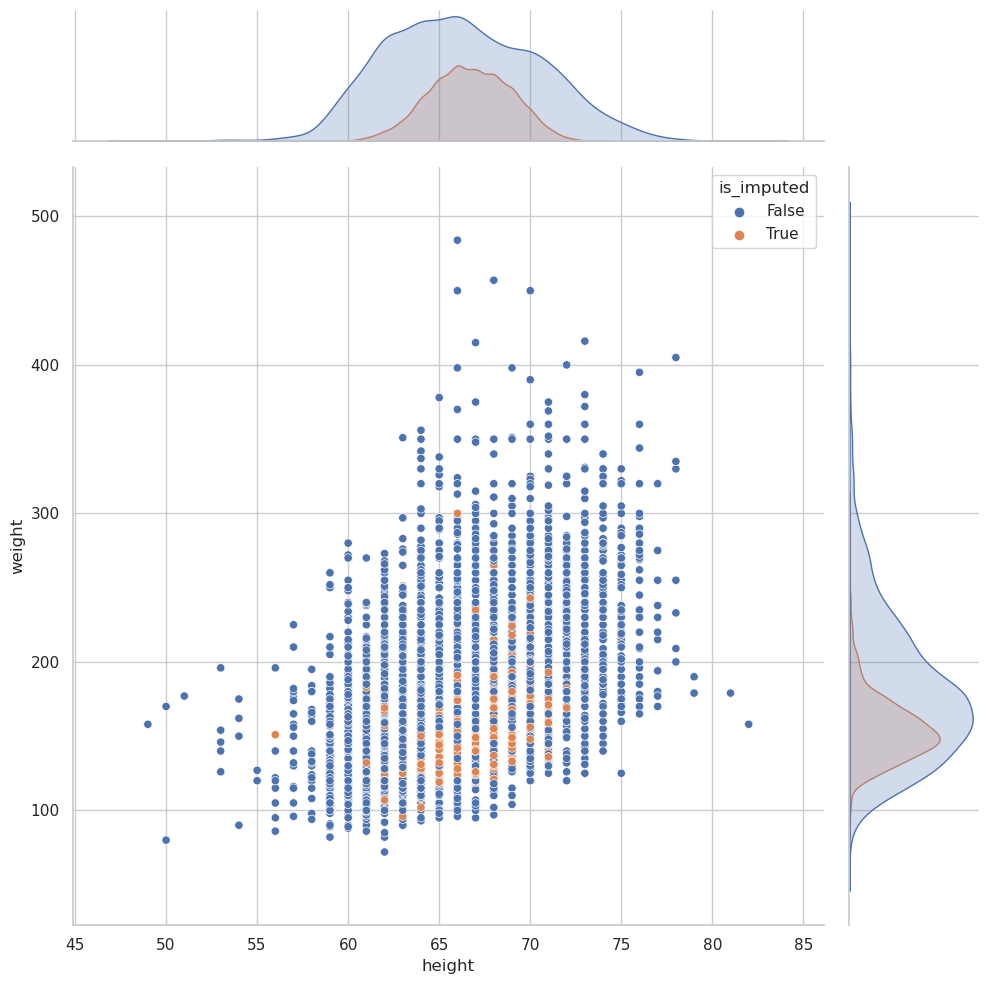

In [58]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        height=10,
        show_marginal=True
    )
);

### Model based imputation

In [80]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by="height")
    .transform_column( # Insert dummy values then iterate with a model.
        "weight",
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix="_imp",
        only_missing=False
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
99705.0,53.0,196.0,Female,40.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [97]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols(
            formula="height ~ weight + gender + age", 
            data=df,
            )
    )
    .fit()
)


In [98]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values


SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [102]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values

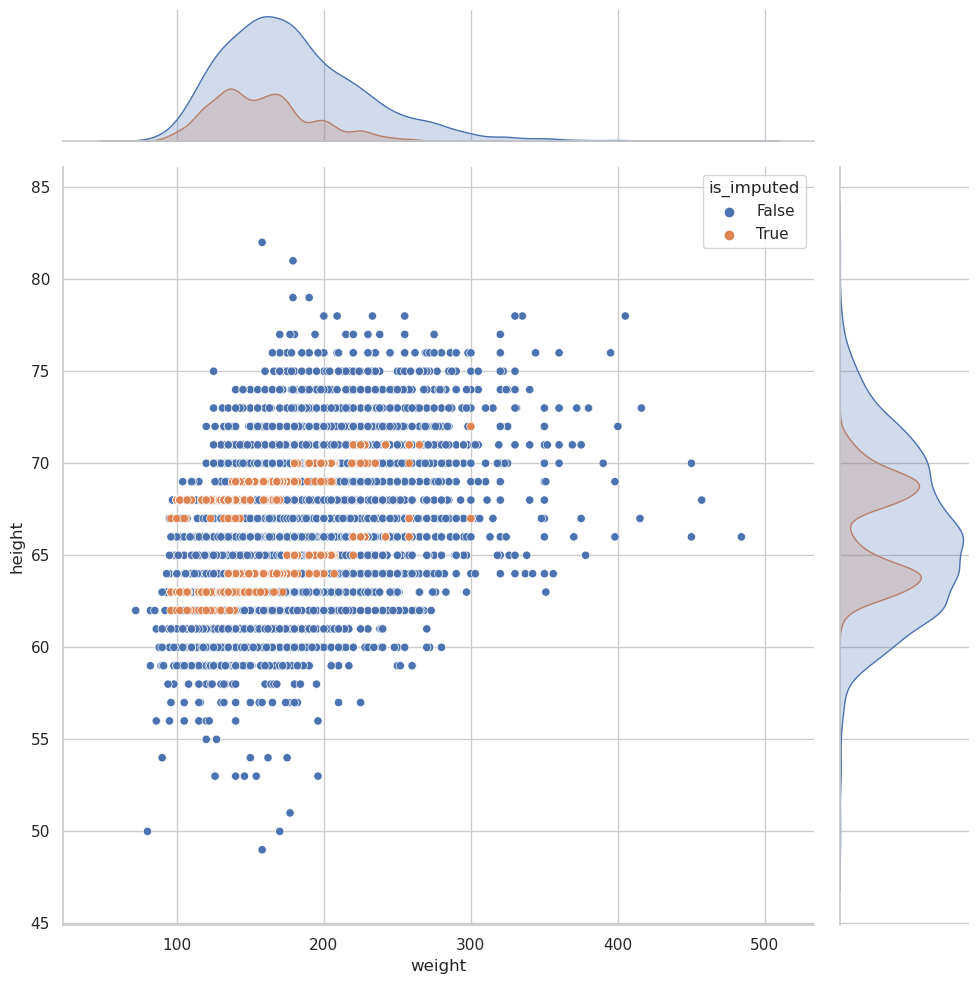

In [105]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x="weight",
        y="height",
        height=10,
        show_marginal=True
    )
);